# Extrapolation of solutions for the first Gaussian fit of HC$_3$N

For HC$_3$N, we did a fit using as initial guesses the moments (8, 1 and 2) of emission of the cube. This gave us an initial fit which we filtered according to the following criteria:

    - The error is not zero
    - All values must be non negative 
    - The error fraction is lower than errorfrac=0.5
    - The moment 1 value must be within the range [velinit,velend]
    - The peak value must be larger than rms times snratio minimum
    - The weighted velocity dispersion must be smaller than the absolute
    value of velend-velinit
    - If one parameter in a spectra is np.nan, all the spectra must be nan (sanity
    check)
    - All points must be within a region (part of the input)


What we will do now is take that solution and extrapolate it to fill in the gaps where the solution was not found, so as to use it for a second run of the fit which can give us a better fit for all pixels.


For this code, we need to have the mask where the fits will be searched for (made in file fit_gaussian_spectra_cut_HC3N.ipynb).


In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from scipy.interpolate import griddata
import matplotlib.pyplot as plt


In [2]:
fitdir = 'gaussfit/'
imagefile = "B5-NOEMA+30m-H3CN-10-9_cut_K"
maskfile = fitdir + imagefile + '_mask'
initguessfile = 'casamomentstest/' +imagefile + '_1G_fitparams_filtered.fits'
newguessfile = fitdir + imagefile + '_guesses.fits'

planemask = fits.getdata(maskfile+'.fits')
initguesses = fits.getdata(initguessfile)[:3] #index 3 to 6 are uncertainties
header = fits.getheader(initguessfile)


In [3]:
# as each plane represents a different physical characteristic, and they do not necessarilly 
# correlate between each other, each plane of initguesses must be fit separately
initguessshape = initguesses.shape
yy, xx = np.indices(initguessshape[1:])
newinitguesses = initguesses.copy()
# indexknown = ~np.isnan(initguesses)
for i, plane in enumerate(initguesses):
    indexknown = ~np.isnan(plane)
    newinitguesses[i][~indexknown] = griddata((xx[indexknown], yy[indexknown]),
                                              plane[indexknown],
                                              (xx[~indexknown], yy[~indexknown])
                                             )
    newinitguesses[i][np.where(planemask==0)] = np.nan
    
fits.writeto(newguessfile, newinitguesses, header)

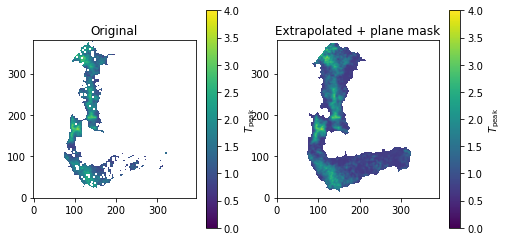

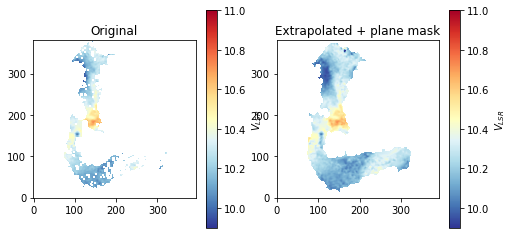

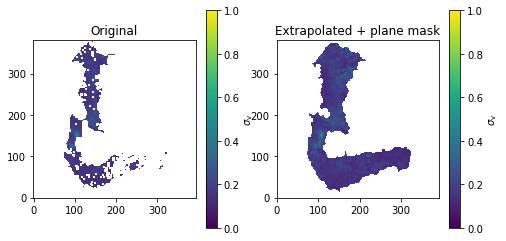

In [7]:
vmin = [0,9.9,0]
vmax = [4,11,1]
cmap = ['viridis', 'RdYlBu_r', 'viridis']
labels = [r'$T_{\mathrm{peak}}$', r'$V_{LSR}$', r'$\sigma_{\mathrm{v}}$']
for i in range(len(newinitguesses)):
    fig = plt.figure(figsize=(8,4))
    
    ax1 = fig.add_subplot(121)
    im1 = ax1.imshow(initguesses[i], origin='lower', cmap=cmap[i], vmin=vmin[i], vmax=vmax[i])
    fig.colorbar(im1, ax=ax1, label=labels[i])
    
    ax1.set_title('Original')

    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(newinitguesses[i], origin='lower', cmap=cmap[i], vmin=vmin[i], vmax=vmax[i])
    fig.colorbar(im2, ax=ax2, label=labels[i])
    ax2.set_title('Extrapolated + plane mask')
    fig.savefig(fitdir + 'extrapolation_comparison_param{}.pdf'.format(i), transparent=False)